In [1]:
import math

import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

import famgpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {torch.cuda.get_device_name(device) if device.type == 'cuda' else 'CPU'}.")

Training on NVIDIA GeForce RTX 3080.


In [2]:
nb_training_points = 999
x_min = -8
x_max = 8

train_x = torch.linspace(x_min, x_max, nb_training_points, device=device)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size(), device=device) * math.sqrt(0.04)

In [3]:
class ConventionalGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ConventionalGPModel, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ApproxGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(ApproxGPModel, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = famgpytorch.kernels.RBFKernelApprox()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

conv_likelihood = gpytorch.likelihoods.GaussianLikelihood(device=device)
conv_model = ConventionalGPModel(train_x, train_y, conv_likelihood)
conv_model.to(device)
conv_model.covar_module.lengthscale = 1

approx_likelihood = gpytorch.likelihoods.GaussianLikelihood(device=device)
approx_model = ApproxGPModel(train_x, train_y, approx_likelihood)
approx_model.to(device)
approx_model.covar_module.lengthscale = 1

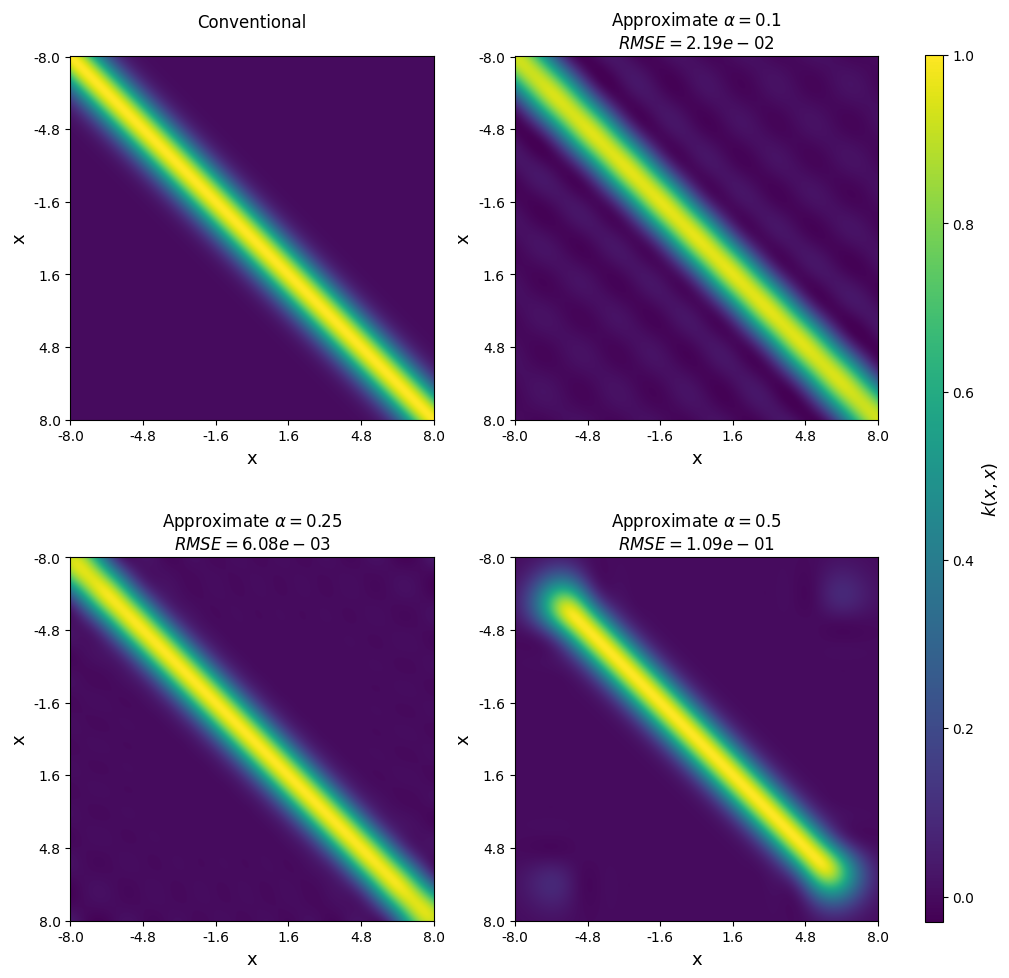

In [4]:
with torch.no_grad():
    conv_f_train = conv_model(train_x)
    conv_train_covar = conv_f_train.covariance_matrix

    approx_model.covar_module.alpha = 0.1
    approx_f_train_0_1 = approx_model(train_x)
    approx_train_covar_0_1 = approx_f_train_0_1.covariance_matrix

    approx_model.covar_module.alpha = 0.25
    approx_f_train_0_25 = approx_model(train_x)
    approx_train_covar_0_25 = approx_f_train_0_25.covariance_matrix

    approx_model.covar_module.alpha = 0.5
    approx_f_train_0_5 = approx_model(train_x)
    approx_train_covar_0_5 = approx_f_train_0_5.covariance_matrix

    rmse_0_1 = torch.sqrt(torch.mean((conv_train_covar - approx_train_covar_0_1)**2))
    rmse_0_25 = torch.sqrt(torch.mean((conv_train_covar - approx_train_covar_0_25)**2))
    rmse_0_5 = torch.sqrt(torch.mean((conv_train_covar - approx_train_covar_0_5)**2))

    fig, axs = plt.subplots(2, 2, figsize=(10, 10), layout='constrained')
    vmin = torch.min(torch.cat((conv_train_covar, approx_train_covar_0_1, approx_train_covar_0_25, approx_train_covar_0_5))).item()
    vmax = torch.max(torch.cat((conv_train_covar, approx_train_covar_0_1, approx_train_covar_0_25, approx_train_covar_0_5))).item()

    for ax, covar, title in zip(
        axs.reshape(4),
        [
            conv_train_covar.to('cpu'),
            approx_train_covar_0_1.to('cpu'),
            approx_train_covar_0_25.to('cpu'),
            approx_train_covar_0_5.to('cpu')
        ],
        [
            "Conventional\n",
            f"Approximate $\\alpha = 0.1$\n$RMSE = {rmse_0_1.item():.2e}$",
            f"Approximate $\\alpha = 0.25$\n$RMSE = {rmse_0_25.item():.2e}$",
            f"Approximate $\\alpha = 0.5$\n$RMSE = {rmse_0_5.item():.2e}$"
        ]
    ):
        im = ax.imshow(covar.numpy(), cmap=plt.colormaps['viridis'], vmin=vmin, vmax=vmax)

        ax.set_title(title)
        ax.set_xlabel('x', fontsize=13)
        ax.set_ylabel('x', fontsize=13)
        ax.set_xticks(np.linspace(0, nb_training_points - 1, min(nb_training_points, 6)))
        ax.set_yticks(np.linspace(0, nb_training_points - 1, min(nb_training_points, 6)))
        ax.set_xticklabels(np.round(np.linspace(x_min, x_max, min(nb_training_points, 6)), 2))
        ax.set_yticklabels(np.round(np.linspace(x_min, x_max, min(nb_training_points, 6)), 2))
        ax.grid(False)


    cbar = fig.colorbar(im, ax=axs[:, 1], pad=0.1, aspect=50, shrink=0.906)
    cbar.ax.set_ylabel('$k(x,x)$', fontsize=13)
